In [1]:
import numpy as np
import os
import pickle

import gym
import matplotlib.pyplot as plt
#from scripts.buffer_utils import LoadSequenceDataset
%matplotlib inline

In [2]:
import h5py

In [3]:
import collections

In [4]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [5]:
import pdb

In [6]:
import sys
sys.argv = ['']

In [7]:
from diffuser.datasets.normalization import  DatasetNormalizer

/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

In [9]:

def load_data(data_path):
    data_dict = {}
    with h5py.File(data_path, "r", libver="latest", swmr=True) as dataset_file:
        for k in get_keys(dataset_file):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]
    return data_dict

In [10]:

tasks = ['walker2d-medium-replay-v2', 'walker2d-medium-v2', 'walker2d-medium-expert-v2',
          'hopper-medium-replay-v2', 'hopper-medium-v2', 'hopper-medium-expert-v2',
          'halfcheetah-medium-replay-v2', 'halfcheetah-medium-v2', 'halfcheetah-medium-expert-v2',]
         

env_list = []
data_list = []
for task in tasks:
    env = gym.make(task)
    data = env.get_dataset()
    
    env_list.append(env)
    data_list.append(data)

/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


In [11]:
for i in range(len(tasks)):
    print(f"task: {tasks[i]}\t data_size: {data_list[i]['observations'].shape[0]}")

task: walker2d-medium-replay-v2	 data_size: 302000
task: walker2d-medium-v2	 data_size: 1000000
task: walker2d-medium-expert-v2	 data_size: 1999995
task: hopper-medium-replay-v2	 data_size: 402000
task: hopper-medium-v2	 data_size: 1000000
task: hopper-medium-expert-v2	 data_size: 1999906
task: halfcheetah-medium-replay-v2	 data_size: 202000
task: halfcheetah-medium-v2	 data_size: 1000000
task: halfcheetah-medium-expert-v2	 data_size: 2000000


In [12]:
for i in range(len(tasks)):
    print(f"task: {tasks[i]}\t obs space: {data_list[i]['observations'].shape[-1]}")

task: walker2d-medium-replay-v2	 obs space: 17
task: walker2d-medium-v2	 obs space: 17
task: walker2d-medium-expert-v2	 obs space: 17
task: hopper-medium-replay-v2	 obs space: 11
task: hopper-medium-v2	 obs space: 11
task: hopper-medium-expert-v2	 obs space: 11
task: halfcheetah-medium-replay-v2	 obs space: 17
task: halfcheetah-medium-v2	 obs space: 17
task: halfcheetah-medium-expert-v2	 obs space: 17


In [13]:
for i in range(len(tasks)):
    print(f"task: {tasks[i]}\t act space: {data_list[i]['actions'].shape[-1]}")

task: walker2d-medium-replay-v2	 act space: 6
task: walker2d-medium-v2	 act space: 6
task: walker2d-medium-expert-v2	 act space: 6
task: hopper-medium-replay-v2	 act space: 3
task: hopper-medium-v2	 act space: 3
task: hopper-medium-expert-v2	 act space: 3
task: halfcheetah-medium-replay-v2	 act space: 6
task: halfcheetah-medium-v2	 act space: 6
task: halfcheetah-medium-expert-v2	 act space: 6


In [14]:
def sequence_dataset(dataset, kitchen=True):
    sequences = []

    N = dataset["rewards"].shape[0]
    data_ = collections.defaultdict(list)
    use_timeouts = "timeouts" in dataset

    episode_step = 0
    for i in range(N):
        done_bool = bool(dataset["terminals"][i])
        if use_timeouts:
            final_timestep = dataset["timeouts"][i]
        else:
            final_timestep = episode_step == env.max_episode_steps - 1

        for k in ["observations", "rewards", "actions", "terminals"]:
            if "metadata" in k:
                continue
            data_[k].append(dataset[k][i])

        if done_bool or final_timestep:
            episode_step = 0
            episode_data = {}
            for k in data_:
                episode_data[k] = np.array(data_[k])

            if kitchen:
                episode_data = process_kitchen_episode(episode_data)
            sequences.append(episode_data)
            data_ = collections.defaultdict(list)
            
        episode_step += 1
    return sequences

def process_kitchen_episode(episode):
    rewards_ = episode["rewards"][1:] - episode["rewards"][:-1]
    rewards = np.concatenate([episode["rewards"][:1], rewards_], axis=0)
    episode["rewards"] = rewards

    obs = episode["observations"]
    episode["observations"] = obs[:, :30]  # remove the goal
    return episode

In [15]:
sequence_data_list = []
for i, data in enumerate(data_list):
    sequence = sequence_dataset(data, kitchen=False)
    sequence_data_list.append(sequence)
    print(f'task: {tasks[i]}, #. of episodes: {len(sequence)}')


task: walker2d-medium-replay-v2, #. of episodes: 1093
task: walker2d-medium-v2, #. of episodes: 1190
task: walker2d-medium-expert-v2, #. of episodes: 2190
task: hopper-medium-replay-v2, #. of episodes: 2041
task: hopper-medium-v2, #. of episodes: 2186
task: hopper-medium-expert-v2, #. of episodes: 3213
task: halfcheetah-medium-replay-v2, #. of episodes: 202
task: halfcheetah-medium-v2, #. of episodes: 1000
task: halfcheetah-medium-expert-v2, #. of episodes: 2000


In [27]:
normalizers = []
for seq in data_list:
    nlz = DatasetNormalizer(seq, "CDFNormalizer")
    normalizers.append(nlz)


[ utils/normalization ] Skipping metadata/algorithm | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/iteration | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/algorithm | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/iteration | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/policy/nonlinearity | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/policy/output_distribution | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/algorithm | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/iteration | <class 'diffuser.datasets.normalization.CDFNormalizer'>
[ utils/normalization ] Skipping metadata/algorithm | <class 'diffuser.datasets.normalization

In [20]:
normed_sequence_data_list = []
for i, seq_data in enumerate(sequence_data_list):
    print(f' process: {i}th dataset')
    for seq in seq_data:
        for k in ['observations', 'actions']:
            normed = normalizers[i].normalize(seq[k], k)
            seq[f'normed_{k}'] = normed

 process: 0th dataset
 process: 1th dataset
 process: 2th dataset
 process: 3th dataset
 process: 4th dataset
 process: 5th dataset
 process: 6th dataset
 process: 7th dataset
 process: 8th dataset
 process: 9th dataset
 process: 10th dataset
 process: 11th dataset


In [21]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        move.append(np.linalg.norm(seq['normed_observations'][:-1] - seq['normed_observations'][1:], axis=-1))
    move = np.concatenate(move).mean()
    print(f'task: {tasks[i]}: avg move in normed space: {move:.2f}')
        

task: walker2d-random-v2: avg move in normed space: 1.20
task: walker2d-medium-replay-v2: avg move in normed space: 1.02
task: walker2d-medium-v2: avg move in normed space: 0.99
task: walker2d-medium-expert-v2: avg move in normed space: 0.89
task: hopper-random-v2: avg move in normed space: 0.74
task: hopper-medium-replay-v2: avg move in normed space: 0.64
task: hopper-medium-v2: avg move in normed space: 0.57
task: hopper-medium-expert-v2: avg move in normed space: 0.56
task: halfcheetah-random-v2: avg move in normed space: 2.75
task: halfcheetah-medium-replay-v2: avg move in normed space: 2.47
task: halfcheetah-medium-v2: avg move in normed space: 2.58
task: halfcheetah-medium-expert-v2: avg move in normed space: 2.64


In [40]:
move > move

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [44]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        if seq['observations'].shape[0] > 1:
            move.append(np.max(seq['observations'][:-1] - seq['observations'][1:], axis=0))
    move = np.stack(move, axis=0).max(0)
    print(f'task: {tasks[i]}: avg move in observation space: {move}')

task: walker2d-random-v2: avg move in observation space: [ 0.05178005  0.31080127  0.40832672  0.2995807   0.5836843   0.42237705
  0.30953854  0.6252134   1.3153262   2.2897305  14.3169985  20.
 17.026667   20.         20.         17.51605    20.        ]
task: walker2d-medium-replay-v2: avg move in observation space: [ 0.04574192  0.25723526  0.3015617   0.2687012   0.77668476  0.35512283
  0.34932345  0.7547519   2.505981    2.2807972  15.680179   20.
 16.804955   20.         20.         19.66047    20.        ]
task: walker2d-medium-v2: avg move in observation space: [ 0.03722775  0.24111012  0.30269295  0.25861615  0.6775481   0.36182365
  0.22673911  0.7462959   2.2837832   2.0446773  14.338617   20.
 19.493793   20.         20.         16.342888   20.        ]
task: walker2d-medium-expert-v2: avg move in observation space: [ 0.03722775  0.24111012  0.30269295  0.25861615  0.6775481   0.36182365
  0.22673911  0.7462959   2.2837832   2.0446773  14.338617   20.
 19.493793   20.    

In [45]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        if seq['observations'].shape[0] > 1:
            move.append(np.min(seq['observations'][:-1] - seq['observations'][1:], axis=0))
    move = np.stack(move, axis=0).min(0)
    print(f'task: {tasks[i]}: avg move in observation space: {move}')

task: walker2d-random-v2: avg move in observation space: [-1.8531561e-02 -2.1450675e-01 -3.6219966e-01 -2.9060808e-01
 -5.0086498e-01 -3.8603172e-01 -2.8550449e-01 -5.4256159e-01
 -1.2777784e+00 -1.6700358e+00 -1.4819661e+01 -2.0000000e+01
 -1.7883709e+01 -2.0000000e+01 -2.0000000e+01 -1.7689268e+01
 -2.0000000e+01]
task: walker2d-medium-replay-v2: avg move in observation space: [ -0.02885497  -0.30675453  -0.39609414  -0.50672543  -0.6504899
  -0.4597482   -0.56095356  -0.6945858   -1.7183199   -1.9008536
 -14.201632   -20.         -17.291649   -20.         -20.
 -16.780897   -20.        ]
task: walker2d-medium-v2: avg move in observation space: [ -0.02267528  -0.27533072  -0.35033476  -0.5268593   -0.58261174
  -0.40127286  -0.4124514   -0.59092605  -1.3286406   -1.4427458
 -15.023482   -20.         -20.         -20.         -20.
 -15.362688   -20.        ]
task: walker2d-medium-expert-v2: avg move in observation space: [ -0.02267528  -0.27533072  -0.35033476  -0.5268593   -0.5826117

In [38]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        if seq['observations'].shape[0] > 1:
            move.append(np.mean(seq['observations'][:-1] - seq['observations'][1:], axis=0))
    move = np.stack(move, axis=0).mean(0)
    print(f'task: {tasks[i]}: avg move in observation space: {move}')

task: walker2d-random-v2: avg move in observation space: [ 0.00797206  0.05653362  0.04596513  0.03031816 -0.02396419  0.04607526
  0.02980812 -0.02341742  0.07427922  0.17417413  0.5786502   0.5178179
  0.17136914  0.0036446   0.5174152   0.16902736  0.00484146]
task: walker2d-medium-replay-v2: avg move in observation space: [ 0.00270912  0.00716893  0.00537118  0.0092389  -0.0029652   0.00512643
  0.01050877 -0.0037962   0.00605794  0.0342964   0.09004144  0.07628462
  0.05049484 -0.00604907  0.07613032  0.0358688   0.00321036]
task: walker2d-medium-v2: avg move in observation space: [ 4.2573659e-04 -5.3901039e-04  1.3974251e-04  7.4226444e-04
  2.2241408e-04  2.6543433e-04  1.1234357e-03  3.9045146e-04
 -4.1702227e-03  1.9549483e-03 -4.7472544e-04  4.3488992e-04
  2.3994225e-03 -5.5727789e-05  4.8881525e-04  2.6564014e-03
 -5.7596120e-04]
task: walker2d-medium-expert-v2: avg move in observation space: [ 2.4999076e-04 -3.9745515e-04  1.0025818e-04  4.1824346e-04
 -2.1469090e-04  1.33

In [26]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        if seq['observations'].shape[0] > 1:
            move.append(np.mean(seq['observations'][1:] - seq['observations'][:-1], axis=0))
    move = np.stack(move, axis=0).mean(0)
    print(f'task: {tasks[i]}: avg move in observation space: {move}')

task: walker2d-medium-replay-v2: avg move in observation space: [-0.00270912 -0.00716893 -0.00537118 -0.0092389   0.0029652  -0.00512643
 -0.01050877  0.0037962  -0.00605794 -0.0342964  -0.09004144 -0.07628462
 -0.05049484  0.00604907 -0.07613032 -0.0358688  -0.00321036]
task: walker2d-medium-v2: avg move in observation space: [-4.2573659e-04  5.3901039e-04 -1.3974251e-04 -7.4226444e-04
 -2.2241408e-04 -2.6543433e-04 -1.1234357e-03 -3.9045146e-04
  4.1702227e-03 -1.9549483e-03  4.7472544e-04 -4.3488992e-04
 -2.3994225e-03  5.5727789e-05 -4.8881525e-04 -2.6564014e-03
  5.7596120e-04]
task: walker2d-medium-expert-v2: avg move in observation space: [-2.4999076e-04  3.9745515e-04 -1.0025818e-04 -4.1824346e-04
  2.1469090e-04 -1.3357225e-04 -8.0992305e-04 -2.4507628e-04
  4.2364709e-03 -1.0198945e-03  3.1291039e-04  2.7698732e-04
 -1.4188742e-03 -5.3419214e-04 -3.2833547e-04 -2.8187637e-03
 -7.9623991e-05]
task: hopper-medium-replay-v2: avg move in observation space: [-0.00161659 -0.0016316

In [27]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        if seq['observations'].shape[0] > 1:
            move.append(seq['observations'][1:] - seq['observations'][:-1])
    move = np.concatenate(move, axis=0).std(0)
    print(f'task: {tasks[i]}: avg move in observation space: {move}')

task: walker2d-medium-replay-v2: avg move in observation space: [0.00685218 0.02260151 0.02752185 0.03587779 0.09090497 0.02617386
 0.03780273 0.0986196  0.22164923 0.18404894 1.7696226  2.3900485
 2.3512735  3.6518528  2.326939   2.4979243  3.9900918 ]
task: walker2d-medium-v2: avg move in observation space: [0.00636018 0.01410378 0.01651501 0.02658458 0.06713465 0.01590483
 0.03204343 0.09402363 0.18204817 0.15524888 0.9738407  1.4682161
 2.072615   2.9000418  1.2081465  1.9169734  3.7267084 ]
task: walker2d-medium-expert-v2: avg move in observation space: [0.00609373 0.01295773 0.01818335 0.02779843 0.0847126  0.01196549
 0.0336789  0.09119985 0.17461497 0.14902899 0.85315174 1.3444748
 2.070763   2.8253264  0.98232615 1.7811747  3.2572074 ]
task: hopper-medium-replay-v2: avg move in observation space: [0.00923187 0.00586204 0.01151643 0.01310909 0.05063912 0.09027302
 0.14681458 0.6180947  0.6931456  0.61754316 1.1464046 ]
task: hopper-medium-v2: avg move in observation space: [0.0

()

In [24]:
for i in range(len(tasks)):
    seq_data = sequence_data_list[i]
    move = []
    for seq in seq_data:
        move.append(np.linalg.norm(seq['normed_observations'][:-1] - seq['normed_observations'][1:], axis=-1))
    move = np.concatenate(move).mean()
    print(f'task: {tasks[i]}: avg move in normed space: {move:.2f}')

(21, 17)

In [ ]:

for i in range(len(tasks)):
    data_sequence_len = np.array([seq['observations'].shape[0] for seq in sequence_data_list[i]])
    task = tasks[i]
    plt.hist(data_sequence_len, bins=100)
    plt.title(task)
    plt.show()

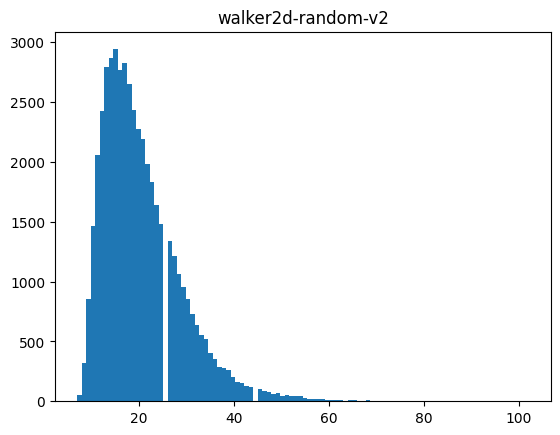

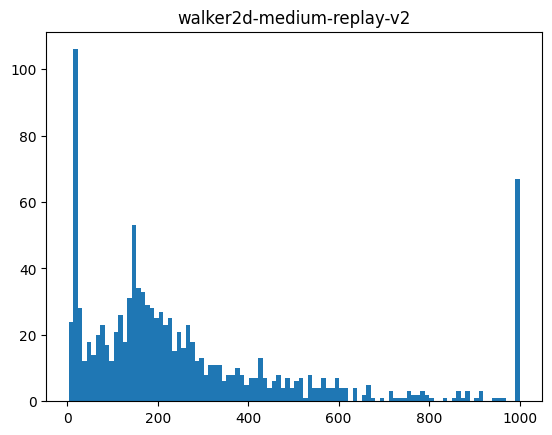

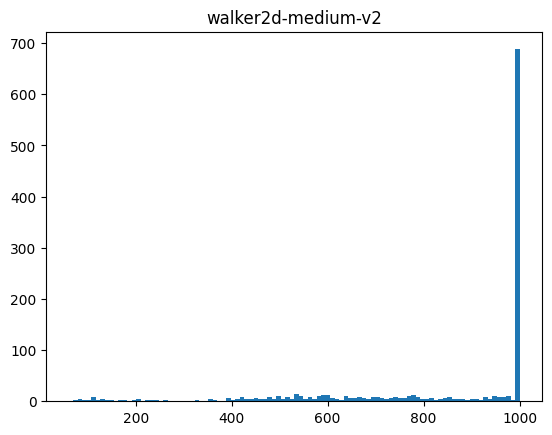

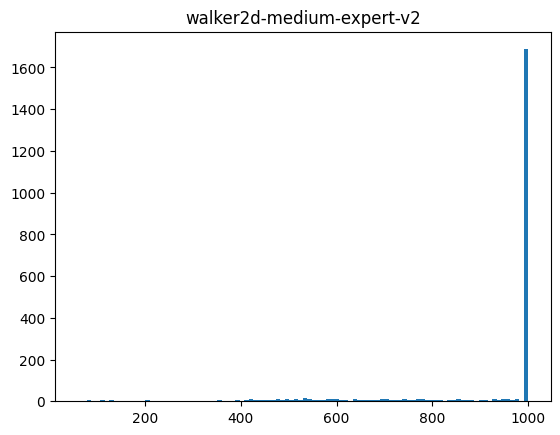

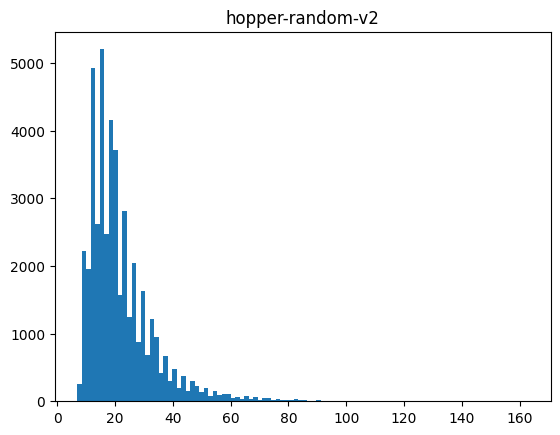

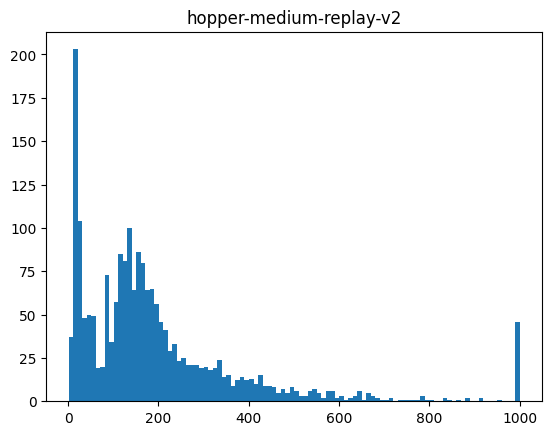

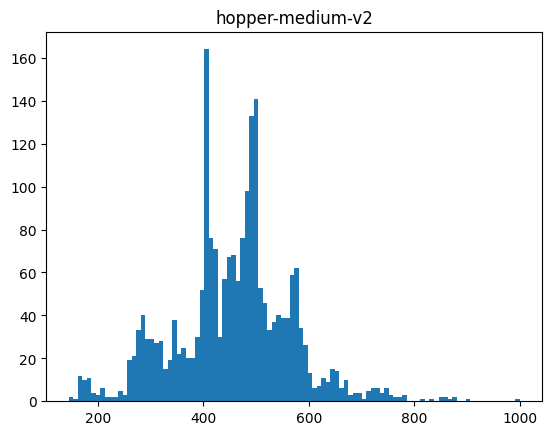

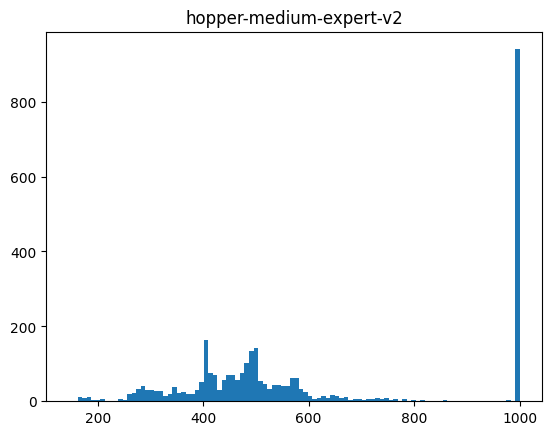

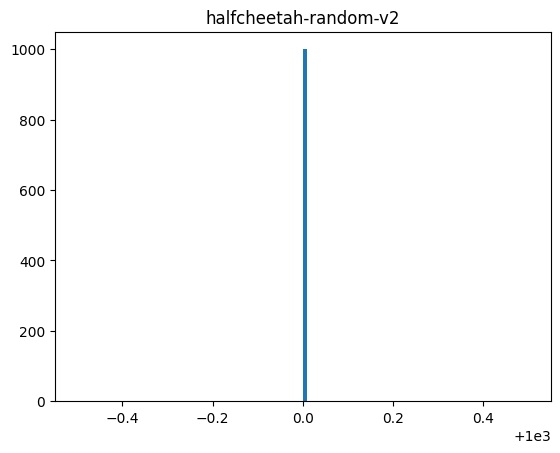

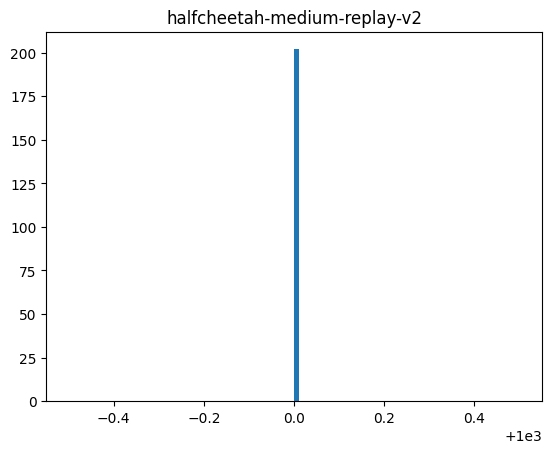

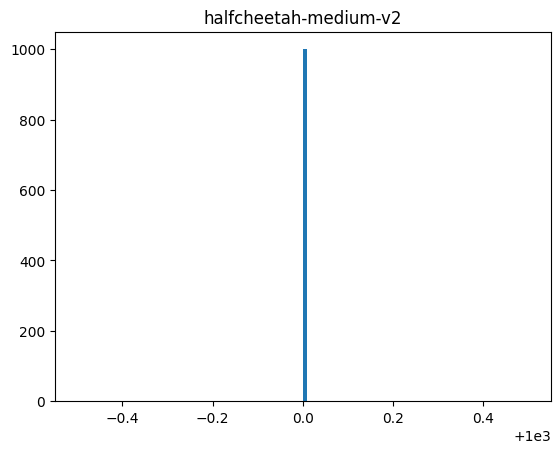

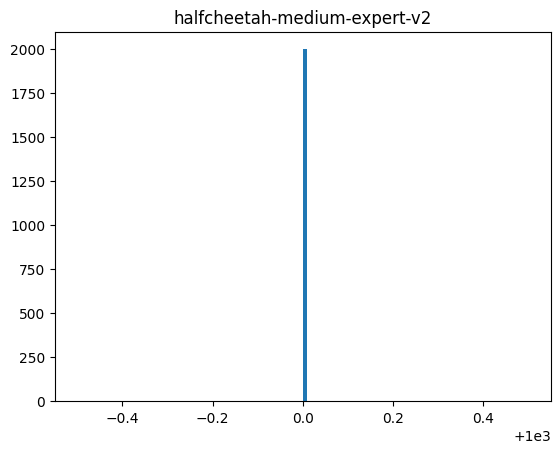

In [30]:
for i in range(len(tasks)):
    data_sequence_len = np.array([seq['observations'].shape[0] for seq in sequence_data_list[i]])
    task = tasks[i]
    plt.hist(data_sequence_len, bins=100)
    plt.title(task)
    plt.show()

In [16]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rewards']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

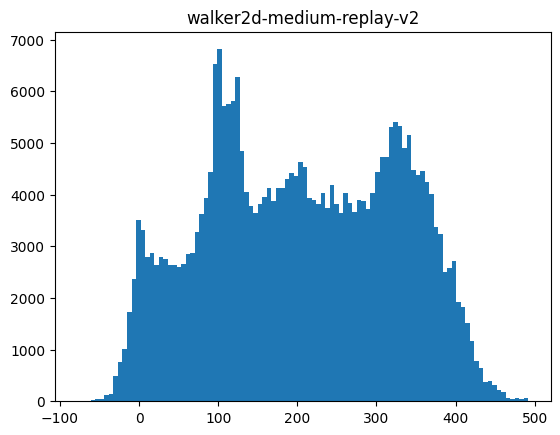

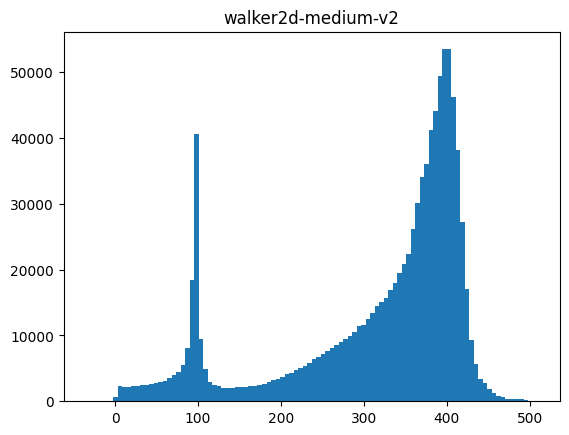

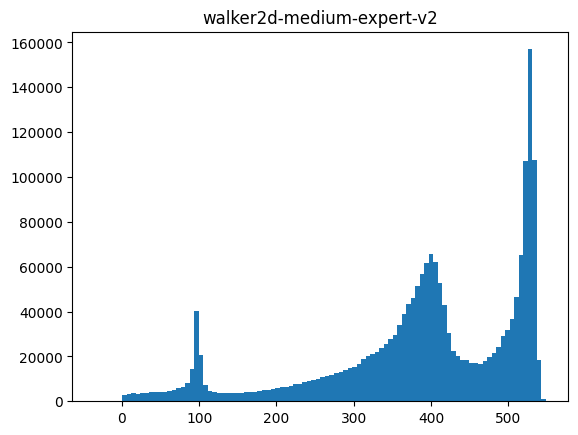

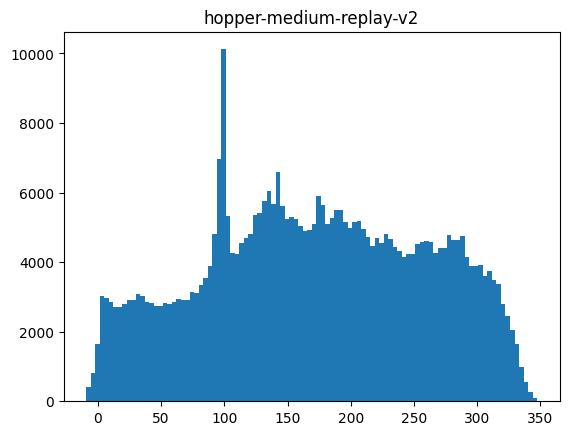

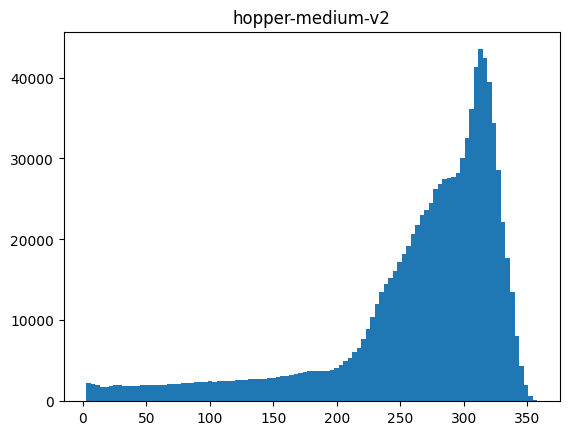

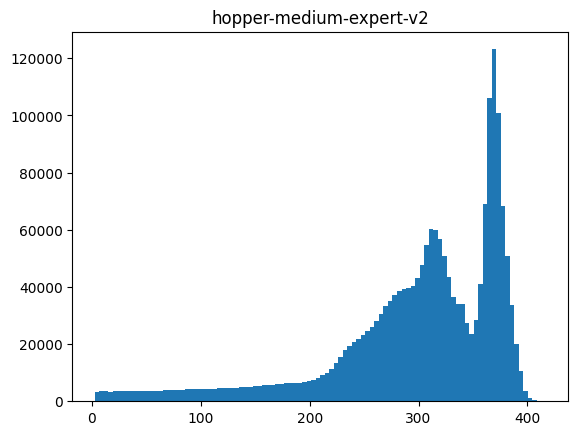

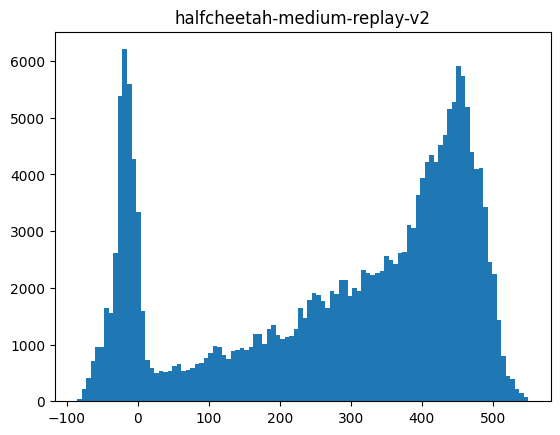

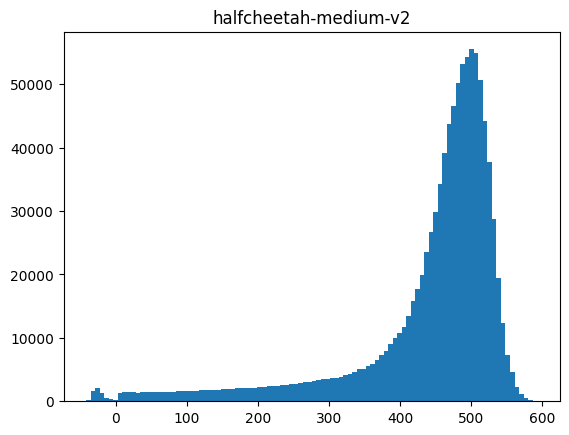

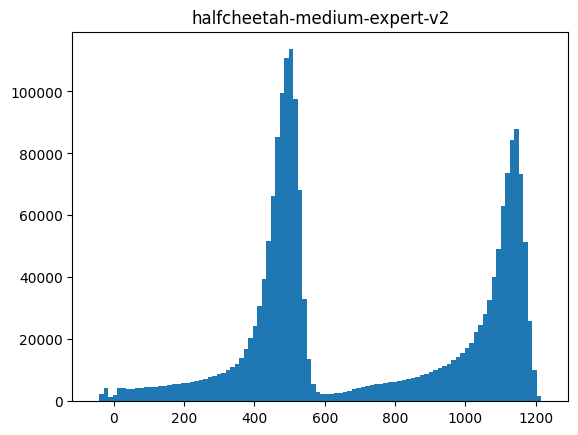

In [17]:
sequence_return_list = []
scale = [400, 400, 400, 400, 400, 400, 400, 400, 1200]

for i in range(len(tasks)):
    sequence_return = np.array(comp_epi_return(sequence_data_list[i]))
    sequence_return_list.append(sequence_return)
    task = tasks[i]
    plt.hist(sequence_return, bins=100)
    plt.title(task)
    plt.show()

In [16]:
def comp_epi_score(dataset, env):
    
    r = []
    for seq in dataset:
        raw_score = sum(seq['rewards'])
        normed_score = env.get_normalized_score(raw_score)
        r.append(normed_score)
        
    return r

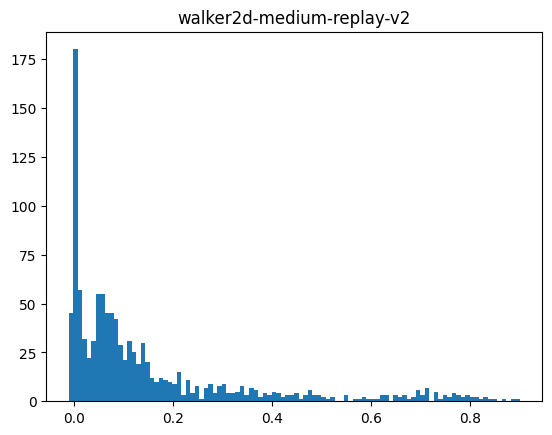

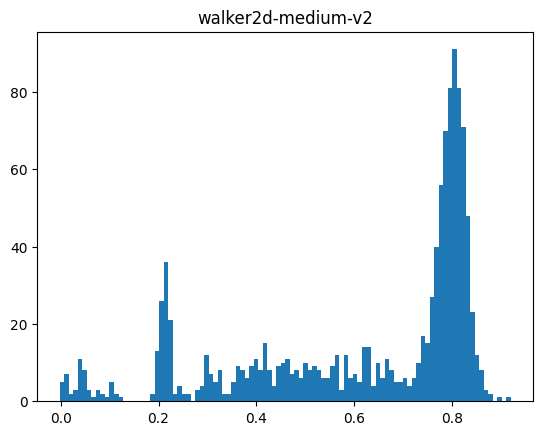

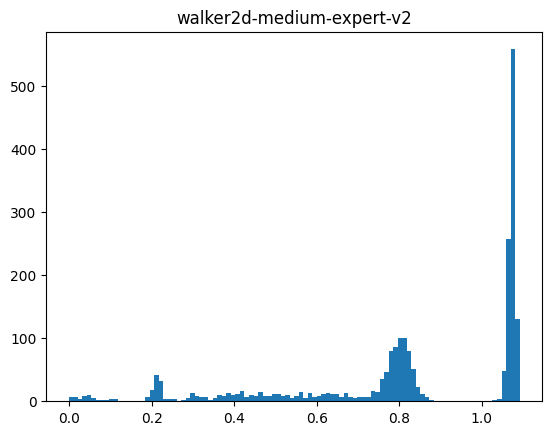

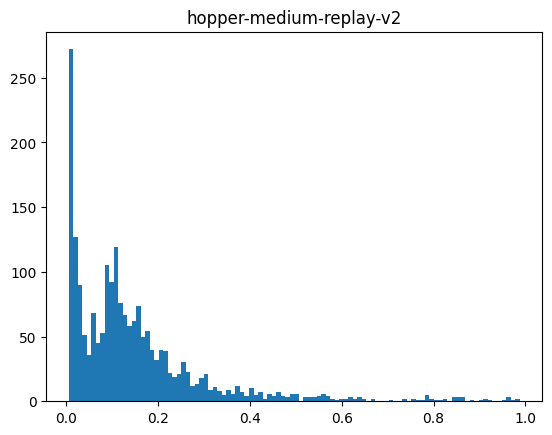

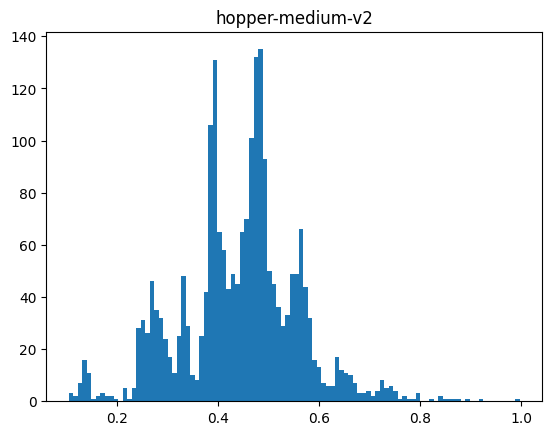

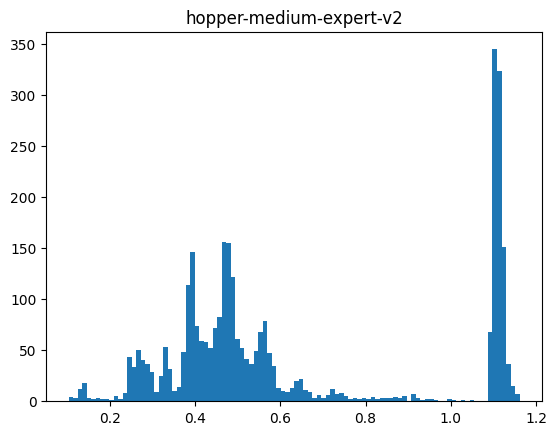

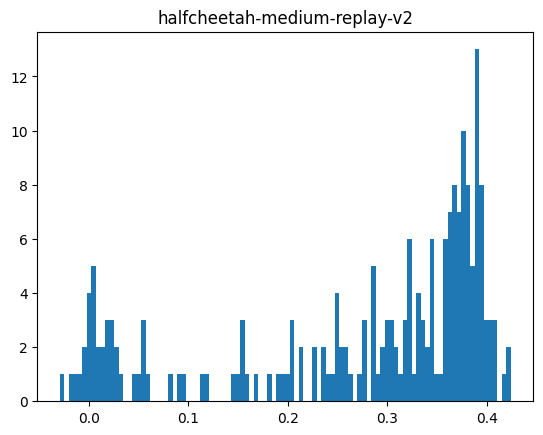

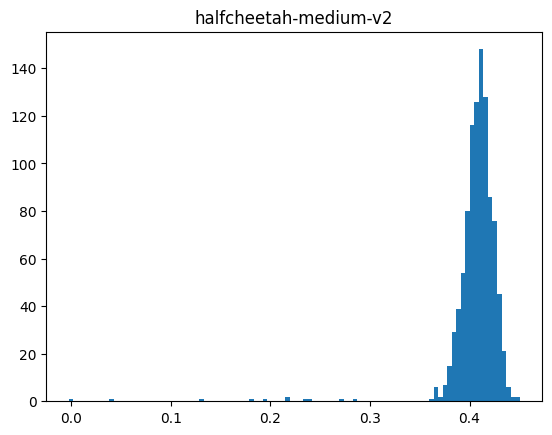

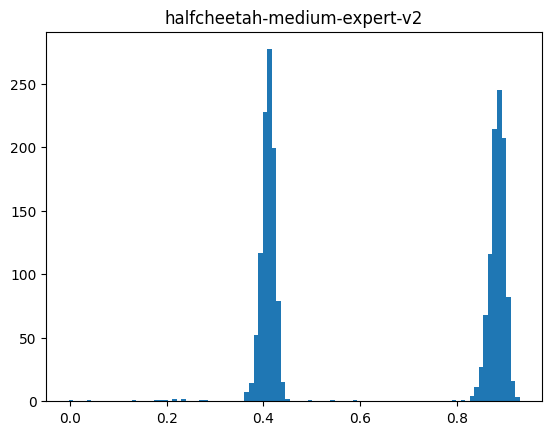

In [17]:
sequence_return_list = []

for i in range(len(tasks)):
    scores = comp_epi_score(sequence_data_list[i], env_list[i])
    task = tasks[i]
    plt.hist(scores, bins=100)
    plt.title(task)
    plt.show()

### Gym-MuJoCo short trajectories

In [18]:
def task_dataset(seq_dataset, task_len):
    
    tasks = []
    
    for seq in seq_dataset:
        
        task_data = collections.defaultdict(list)
        rewards = seq['rewards']
        
        l = rewards.shape[0]
        for i in range(l):
            
            for k in seq:
                task_data[k].append(seq[k][i])
            
            if (i+1) % task_len == 0:
                for k in task_data:
                    task_data[k] = np.array(task_data[k])
                tasks.append(task_data)
                task_data = collections.defaultdict(list)
        
        
        if len(task_data) > 0:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
        
        
    return tasks

In [19]:
task100_dataset_list = [task_dataset(seq, 100) for seq in sequence_data_list]
task50_dataset_list = [task_dataset(seq, 50) for seq in sequence_data_list]
task10_dataset_list = [task_dataset(seq, 10) for seq in sequence_data_list]

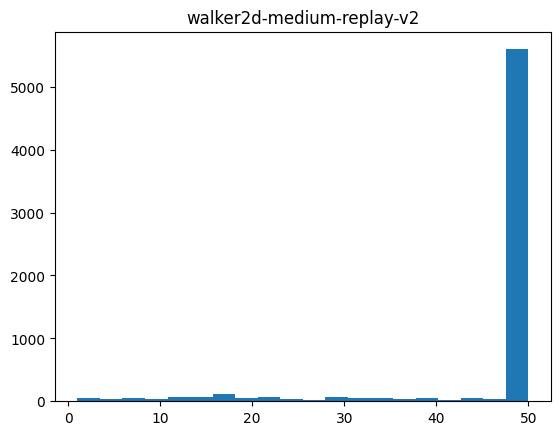

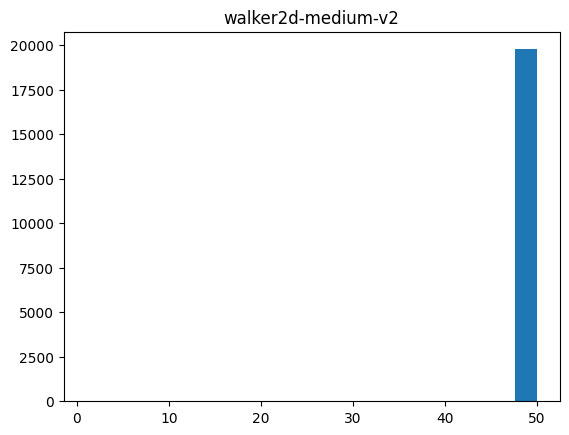

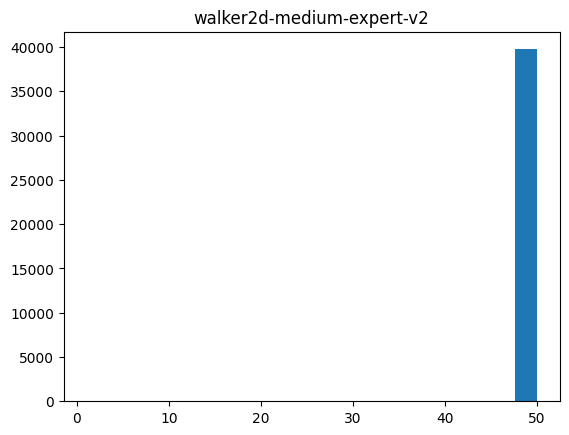

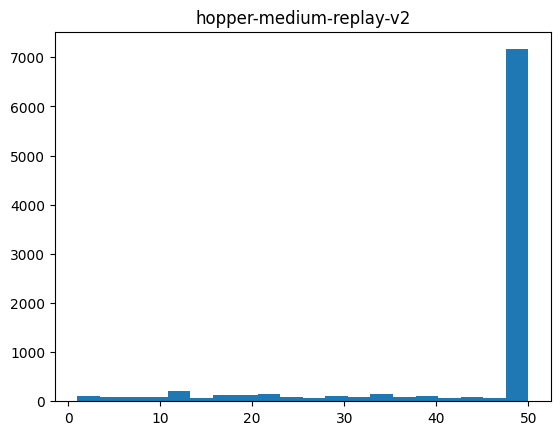

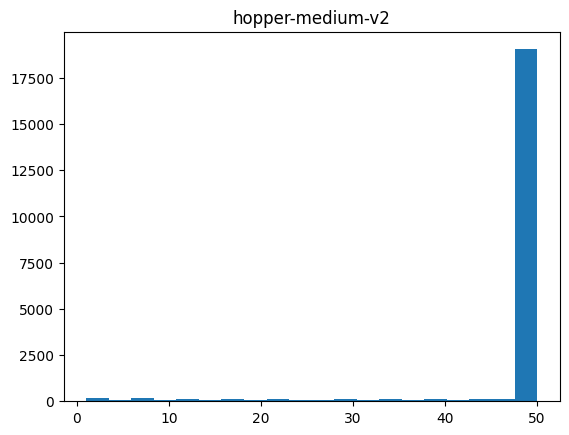

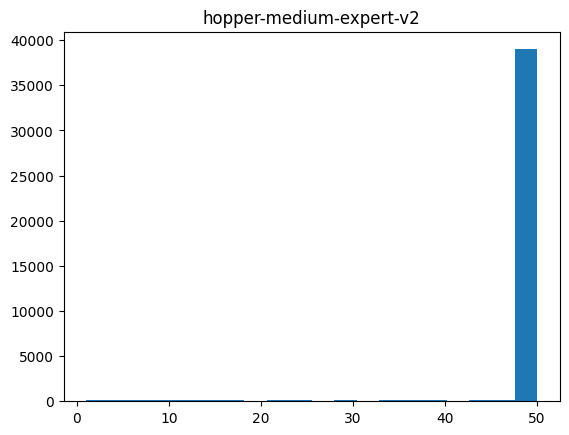

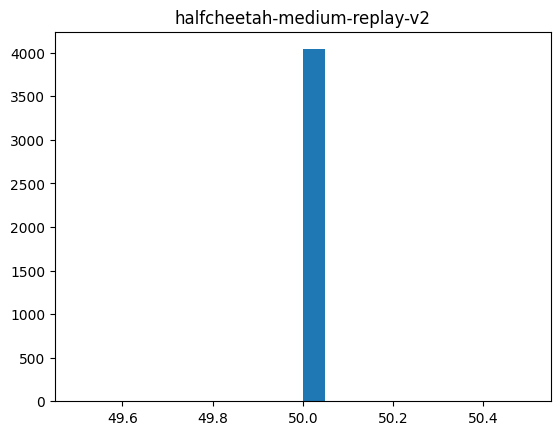

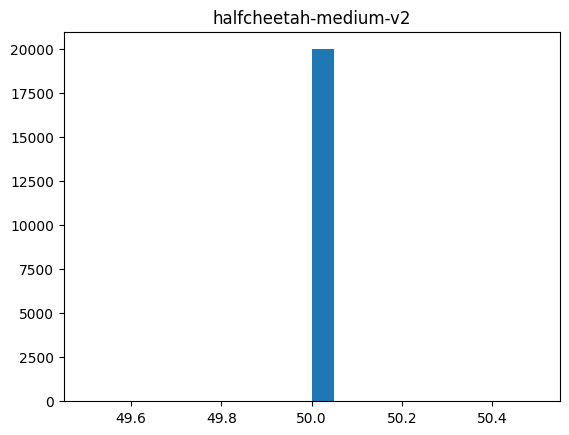

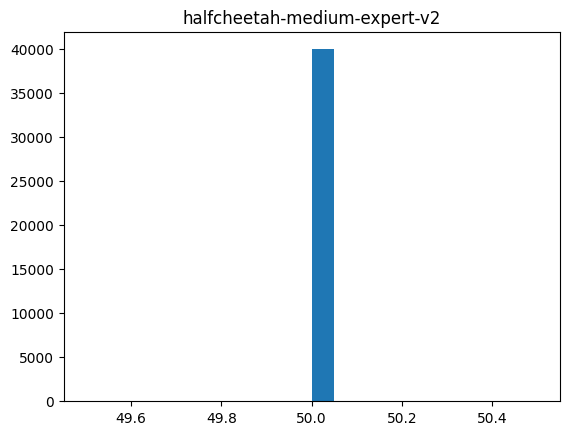

In [18]:
task_len = [[t['rewards'].shape[0] for t in task_dataset] for task_dataset in task_dataset_list]
for i in range(len(tasks)):
    plt.hist(task_len[i], bins=20)
    plt.title(tasks[i])
    plt.show()

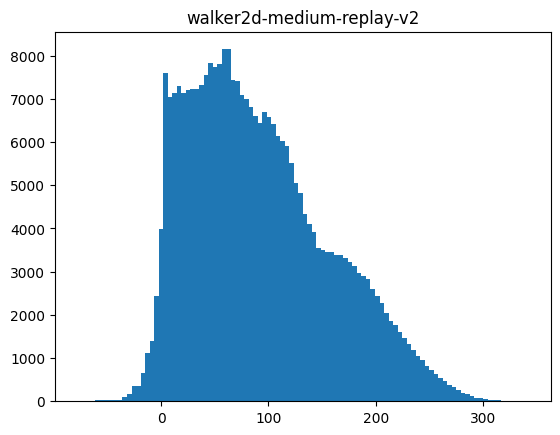

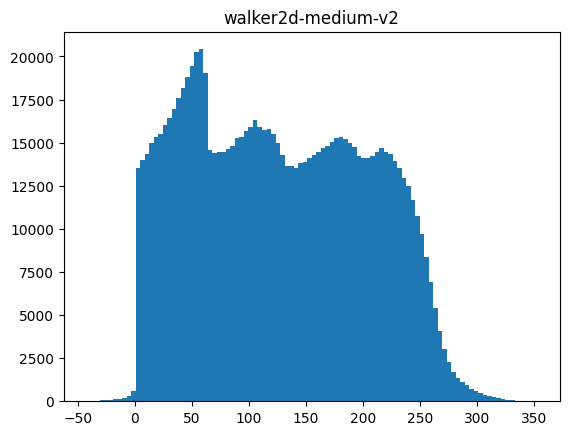

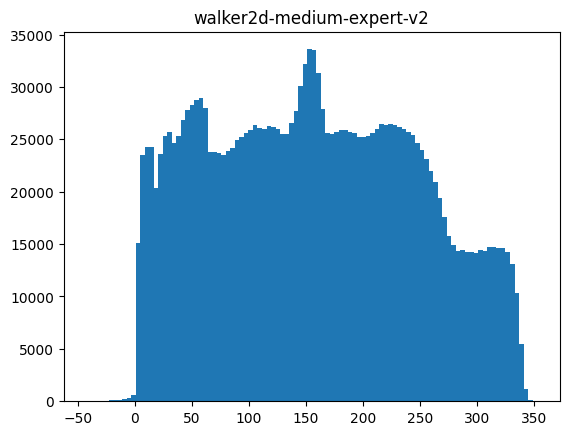

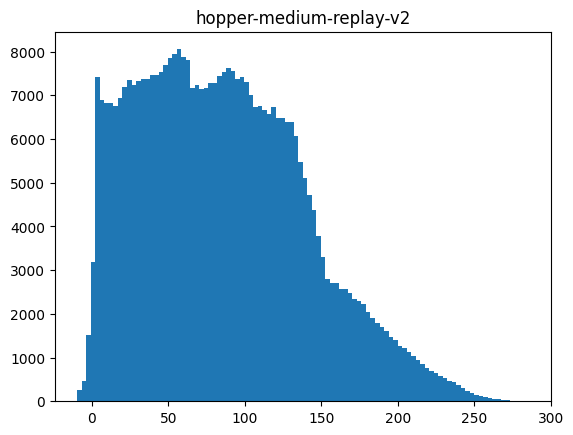

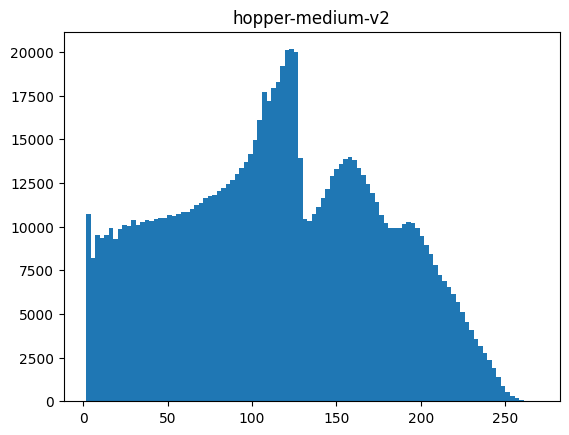

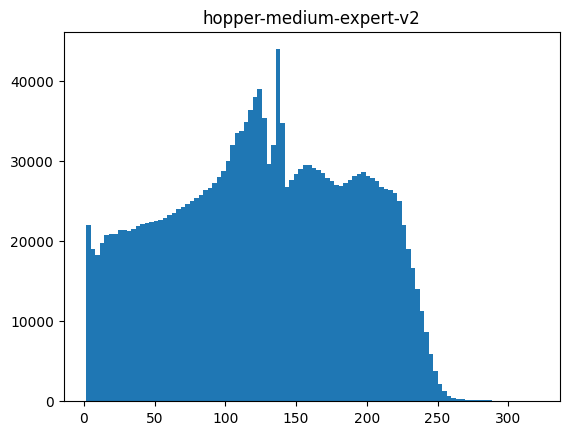

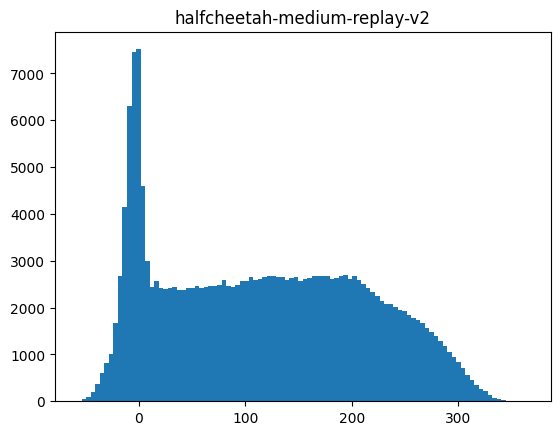

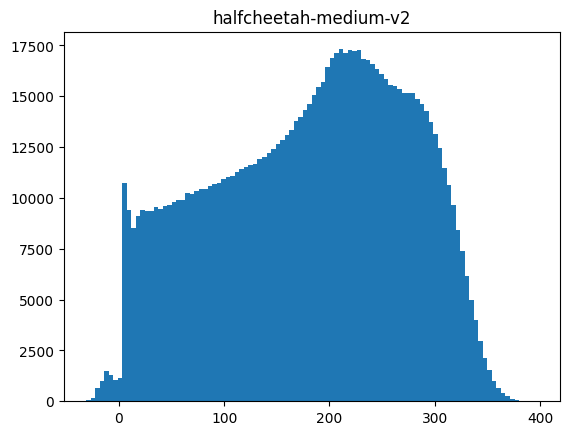

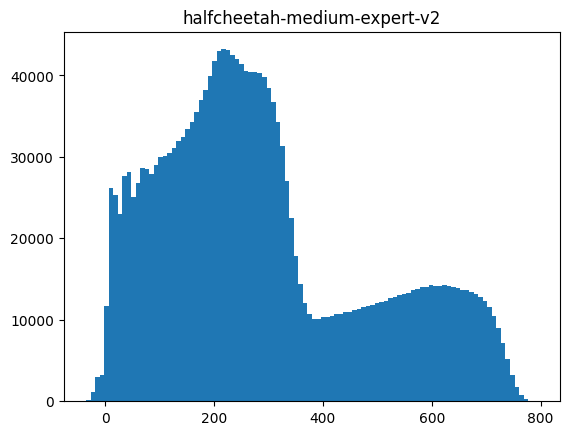

In [20]:
task_return_list = []
scale = [150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 300]

for i in range(len(tasks)):
    task_return = np.array(comp_epi_return(task100_dataset_list[i]))
    task_return_list.append(task_return)
    task = tasks[i]
    plt.hist(task_return, bins=100)
    plt.title(task)
    plt.show()

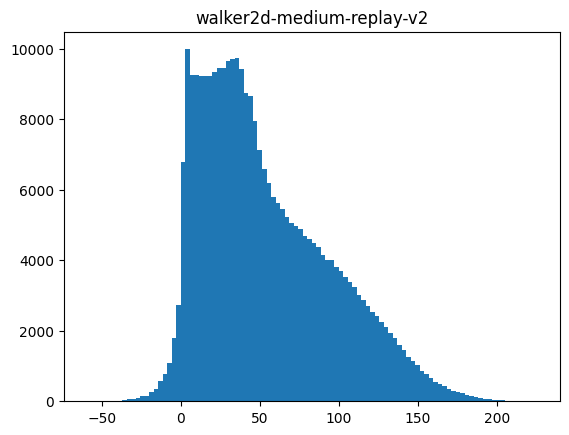

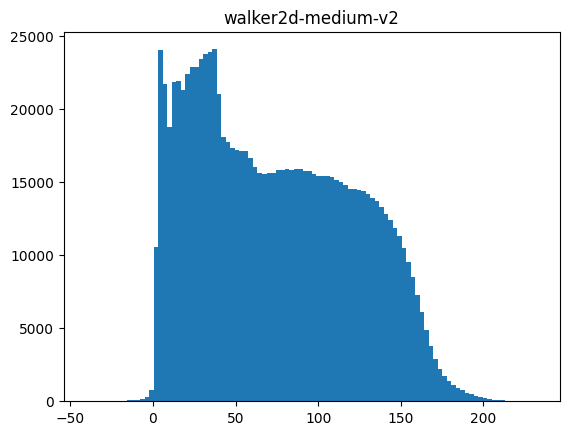

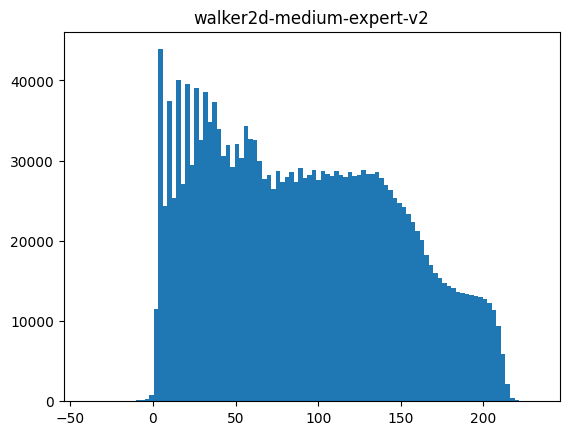

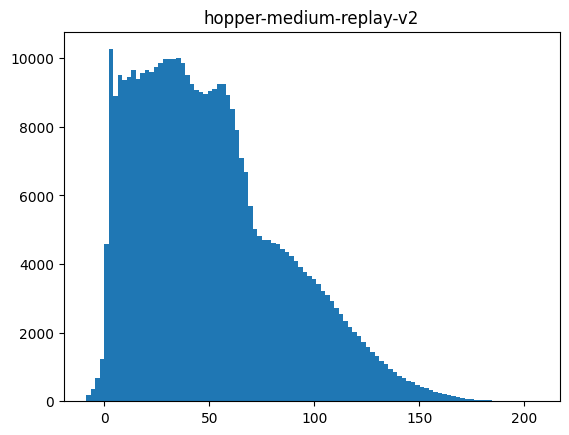

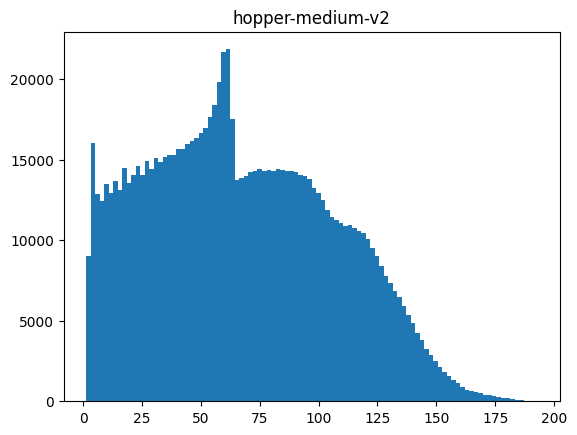

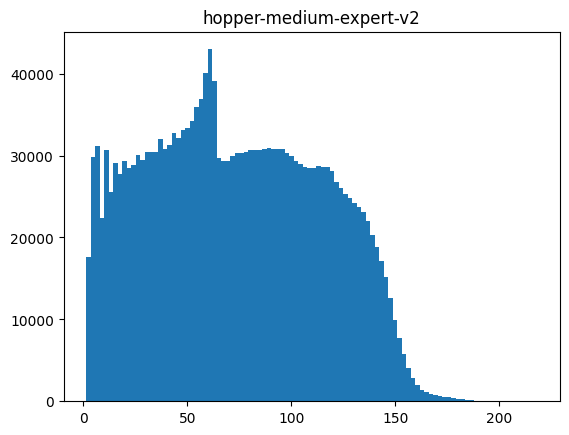

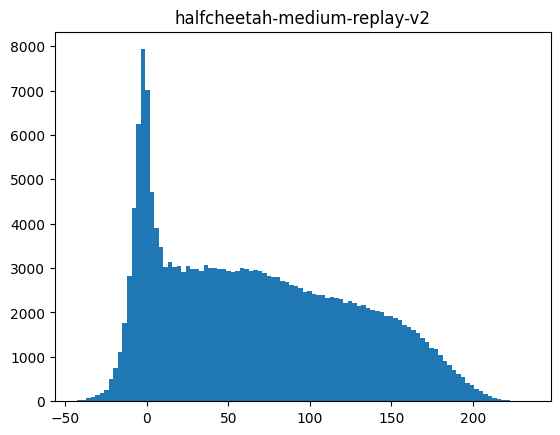

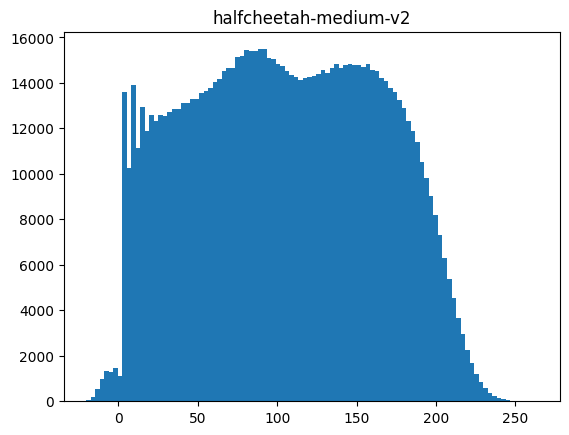

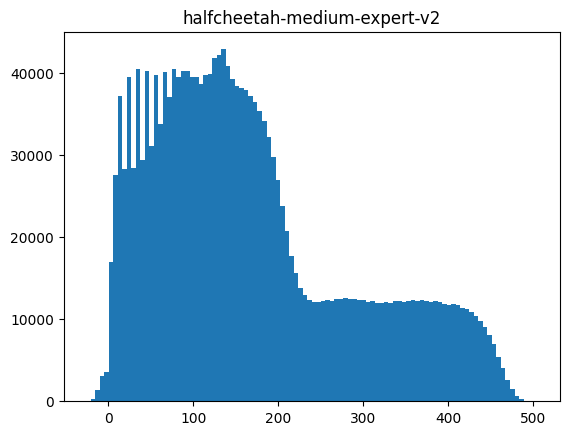

In [21]:
task_return_list = []
scale = [150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 300]

for i in range(len(tasks)):
    task_return = np.array(comp_epi_return(task50_dataset_list[i]))
    task_return_list.append(task_return)
    task = tasks[i]
    plt.hist(task_return, bins=100)
    plt.title(task)
    plt.show()

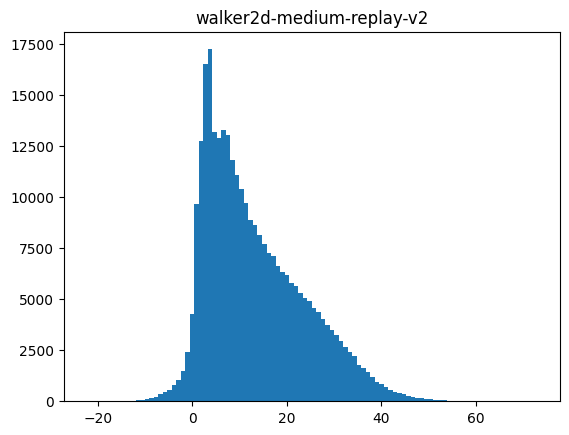

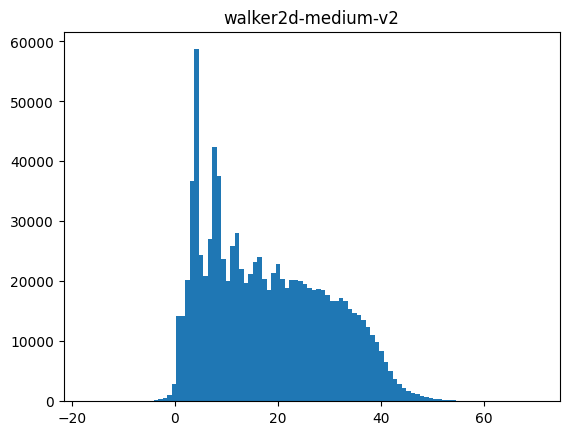

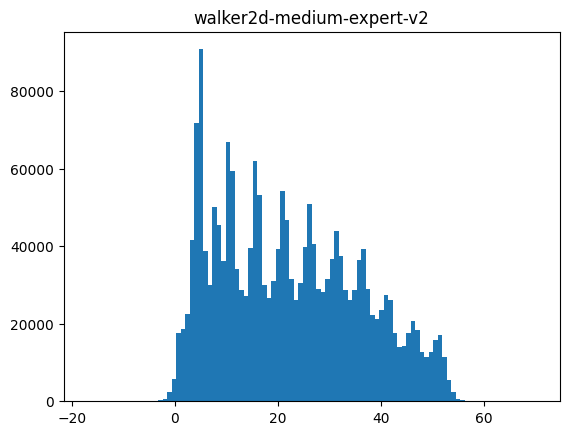

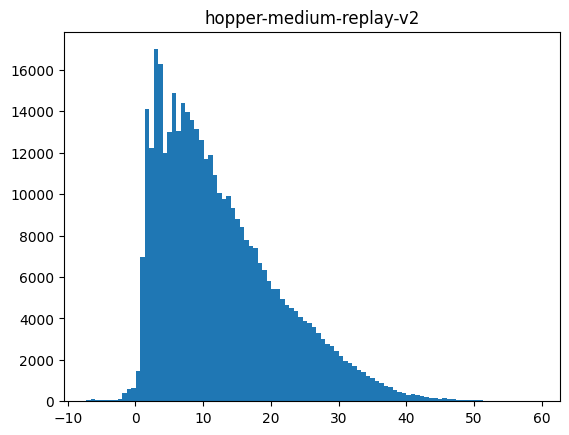

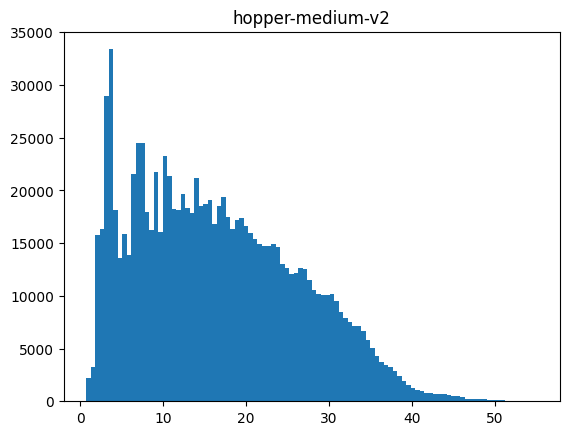

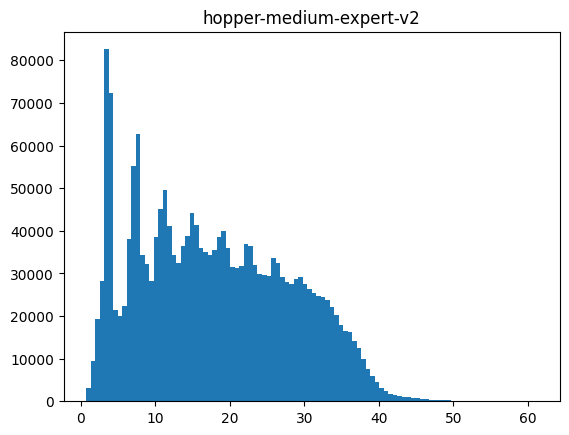

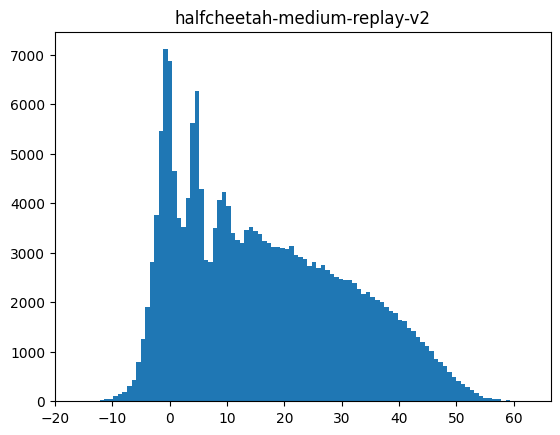

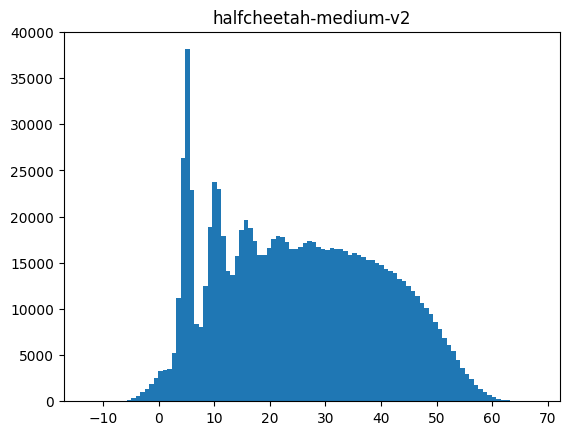

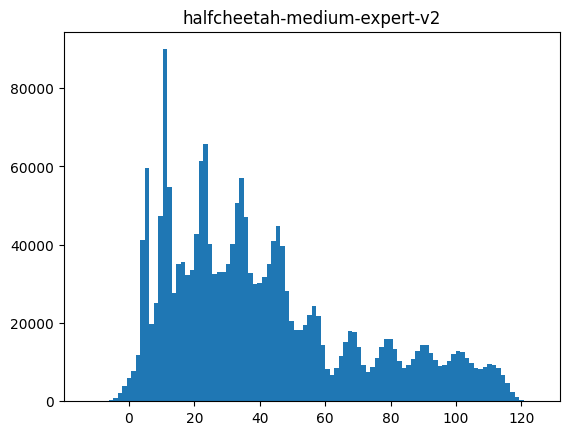

In [22]:
task_return_list = []
scale = [150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 300]

for i in range(len(tasks)):
    task_return = np.array(comp_epi_return(task10_dataset_list[i]))
    task_return_list.append(task_return)
    task = tasks[i]
    plt.hist(task_return, bins=100)
    plt.title(task)
    plt.show()

In [60]:
task_dataset_list[-1][4].keys()

dict_keys(['observations', 'rewards', 'actions', 'terminals', 'normed_observations', 'normed_actions'])

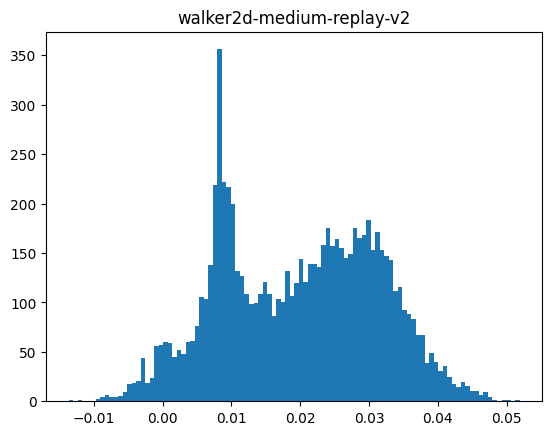

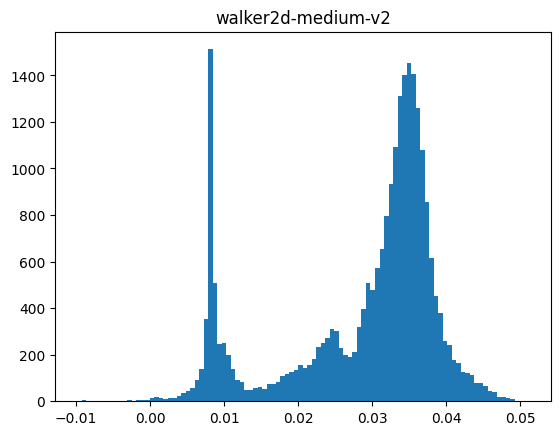

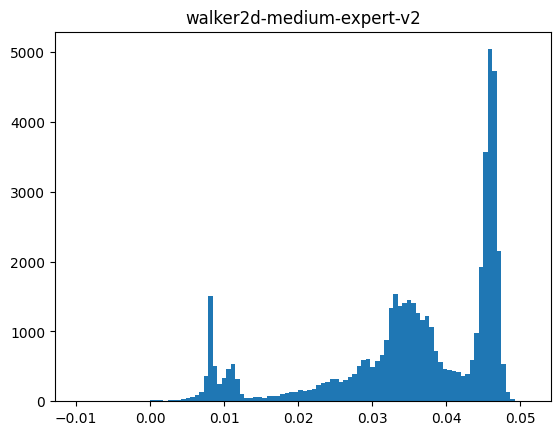

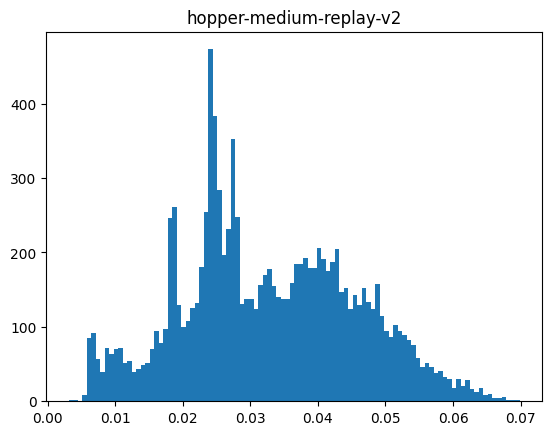

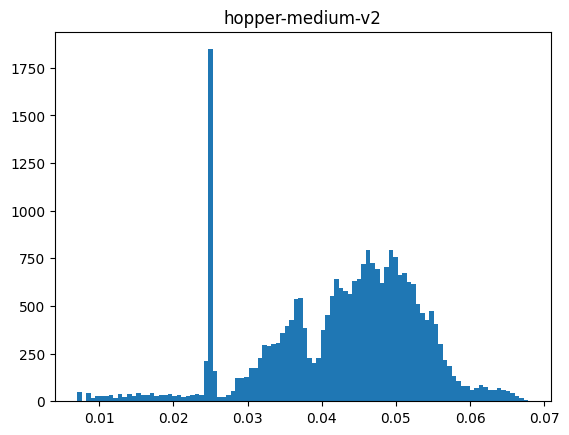

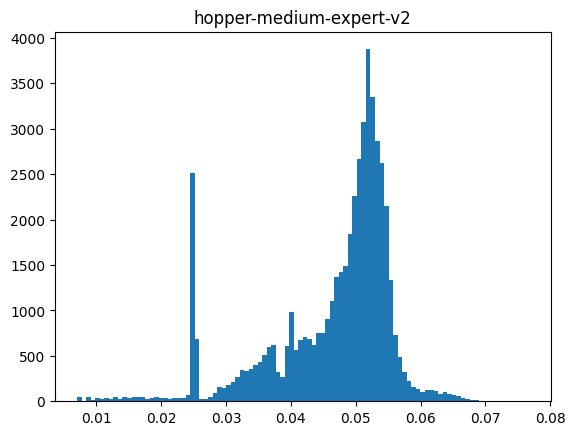

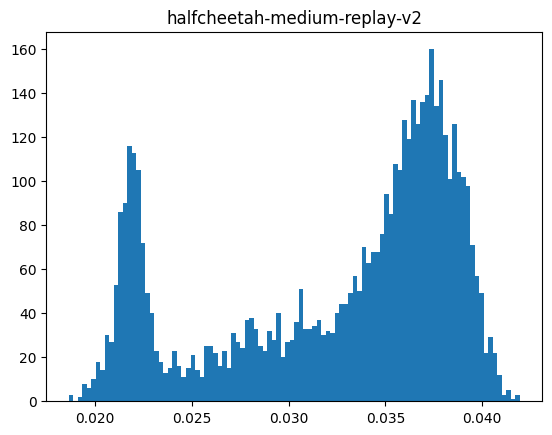

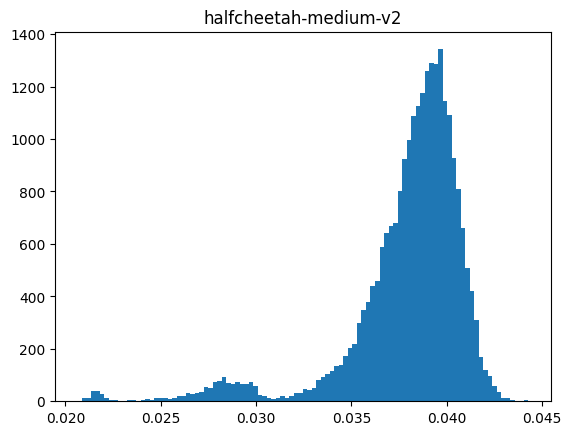

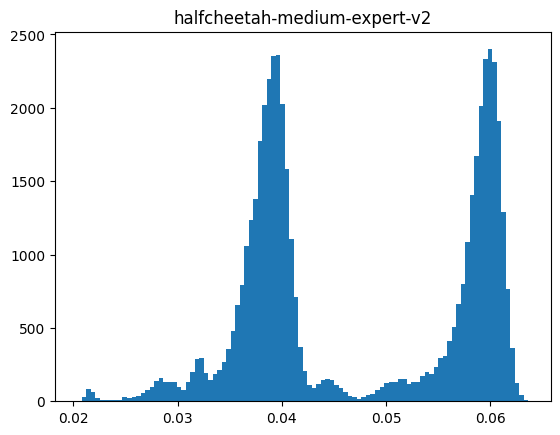

In [23]:


for i in range(len(tasks)):
    scores = comp_epi_score(task_dataset_list[i], env_list[i])
    task = tasks[i]
    plt.hist(scores, bins=100)
    plt.title(task)
    plt.show()

In [72]:
for i in range(len(tasks)):
    scores = comp_epi_score(task_dataset_list[i], env_list[i])
    task = tasks[i]
    plt.hist(scores, bins=100)
    plt.title(task)
    plt.show()

1190

In [100]:
obs = sequence_data_list[1][7]['observations']

move = np.linalg.norm(obs[:-1] - obs[1:], axis=-1)

## Stitched data

### Using Mean of two end states

In [73]:
n_clusters = [5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(task_dataset_list[1])):

    mean_states = np.array([task_dataset_list[1][idx]['observations'][0], task_dataset_list[1][idx]['observations'][-1]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")
    

 ============= clustering with center of two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.50
Calinski-Harabasz Index: 2331.57
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.49
Calinski-Harabasz Index: 1689.76
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.18
Davies-Bouldin Index: 1.54
Calinski-Harabasz Index: 1206.06
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.16
Davies-Bouldin Index: 1.47
Calinski-Harabasz Index: 829.25


(array([133., 231., 108., 517., 303., 126.,  75.,  77., 142.,  91.,  75.,
         57.,  60.,  37.,  20.,  36.,   4.,   2.,   1.,   3.]),
 array([  1. ,  12.9,  24.8,  36.7,  48.6,  60.5,  72.4,  84.3,  96.2,
        108.1, 120. , 131.9, 143.8, 155.7, 167.6, 179.5, 191.4, 203.3,
        215.2, 227.1, 239. ]),
 <BarContainer object of 20 artists>)

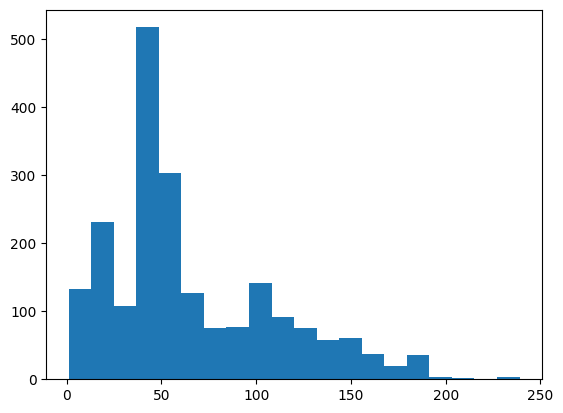

In [114]:
task_len = np.array([t['rewards'].shape[0] for t in tasks])
plt.hist(task_len, bins=20)

In [82]:
(task_len >= 60).sum() / task_len.shape[0]

0.3441077441077441

In [17]:
task_r = np.array([sum(t['rewards']) for t in tasks])

(array([   2.,  676., 1416.,    4.]),
 array([-1,  0,  1,  2,  3]),
 <BarContainer object of 4 artists>)

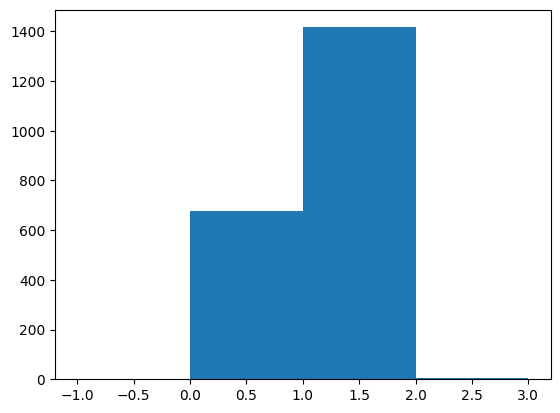

In [25]:
plt.hist(task_r, bins=[-1,0,1,2,3])

In [102]:
tasks[2]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
      dtype=float32)

In [105]:
episodes[1]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [117]:
zero_rewards_idx = np.where(task_r==0.0)[0]

In [118]:
zero_rewards_idx.shape

(676,)

In [97]:
task_len[zero_rewards_idx]

array([  4,   8,   4,   6, 153,   9,  10,  17,  60,   7,   6,   2,   2,
         5,   8,  10,   5,   4,   6,   3,   7,  82,  99,   6,   2,   6,
         4,   2,   2,   2,   6,   5,   4,   4,   2,   6,   2,   2,   4,
         2,   4,   5,   3,   3,   5,   3,   3,   4,   3,   2,   2,   7,
         3,   2,   9,   3,   4,   3,   3,   2,   5,   4,   2,   7,   8,
         8,   4,  99, 132])

In [92]:
len(tasks)

1485

In [72]:
tasks[zero_rewards_idx[4]]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

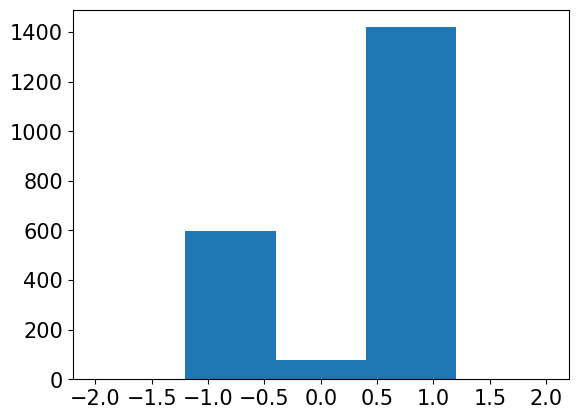

In [53]:
plt.hist(task_r, bins=5)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [35]:
partial_return = np.array(comp_epi_return(tasks))

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

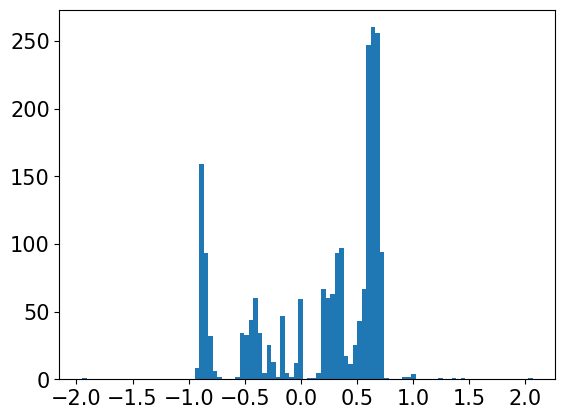

In [46]:
plt.hist(partial_return_v2, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

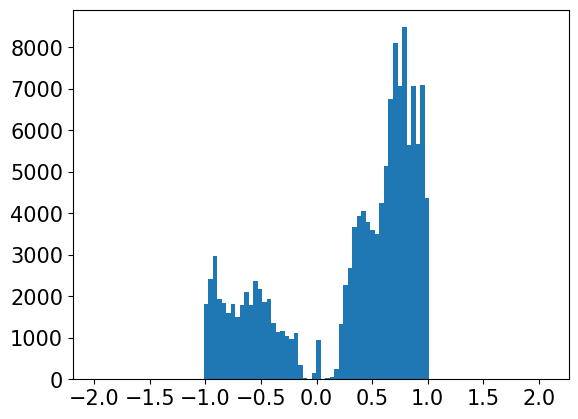

In [36]:
plt.hist(partial_return, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [37]:
partial_return_v2 = np.array(comp_epi_return_v2(tasks))

In [118]:
tasks[85921]['rewards']

IndexError: list index out of range

str

In [107]:
horizon = 60
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [110]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
print(" ============= clustering with last state ============ ")

for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][-1, :30])

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with last state ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.39
Calinski-Harabasz Index: 20792.33
Silhouette Score: 0.19
Davies-Bouldin Index: 1.61
Calinski-Harabasz Index: 14948.81
Silhouette Score: 0.21
Davies-Bouldin Index: 1.40
Calinski-Harabasz Index: 10769.71
Silhouette Score: 0.22
Davies-Bouldin Index: 1.42
Calinski-Harabasz Index: 8045.16
Silhouette Score: 0.23
Davies-Bouldin Index: 1.38
Calinski-Harabasz Index: 6088.27


In [48]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    print(" ============= clustering with whole sequence ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))


for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    print(" ============= clustering with two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with sequence mean ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.88
Calinski-Harabasz Index: 8099.23
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.77
Calinski-Harabasz Index: 6544.18
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.81
Calinski-Harabasz Index: 4461.71
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 3263.22
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 2717.38
 ============= clustering with two end states ============ 
Silhouette Score: 0.23
Davies-Bouldin Index: 1.58
Calinski-Harabasz Index: 9475.58
 ============= clustering with two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.66
Calinski-Harabasz Index: 7339.54

In [51]:
horizon = 40
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [52]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

print(" ============= clustering with whole sequence ============ ")

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    
    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))

print(" ============= clustering with two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

print(" ============= clustering with sequence mean ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

print(" ============= clustering with center of two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.18
Davies-Bouldin Index: 1.87
Calinski-Harabasz Index: 15482.61
 number of clusters: 5 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.78
Calinski-Harabasz Index: 13464.25
 number of clusters: 10 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 10800.71
 number of clusters: 20 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.52
Calinski-Harabasz Index: 7636.55
 number of clusters: 40 ->:
Silhouette Score: 0.26
Davies-Bouldin Index: 1.45
Calinski-Harabasz Index: 5982.83
 ============= clustering with two end states ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.20
Davies-Bouldin Index: 1.80
Calinski-Harabasz Index: 15901.84
 number of clusters: 5 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 14338.28
 number of clusters: 10 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.73
Calinski-Harabasz Index:

In [27]:
episodes[0]['rewards'].shape

(228,)

In [25]:
6.9/np.sqrt(15)

1.7815723392554117

In [ ]:
move = []
for current_path in offline_dataset:
    move.append(current_path["obs"][1:] - current_path["obs"][:-1])
move_mean = np.concatenate(move, axis=0).mean(0)
move_std = np.concatenate(move, axis=0).std(0)

data_buffer = []
done = False
while not done:
    gen_trj = diffuser.sample(...)
    gen_move = gen_trj['obs'][1:] - gen_trj['obs'][:-1]
    
    std_coef = 2.5
    if (move > move_mean + std_coef * move_std).any() or (
        move < move_mean - std_coef * move_std
    ).any():
        print(f"found jumps in {j}th sample")
        continue

    else:
        data_buffer.append(gen_trj)